# Gated PixelCNN receptive fields

Hi everybody!
In this notebook, we will analyse the Gated PixelCNN's block receptive field. Diferent of the original PixelCNN, we expect that the blocks of the Gated PixelCNN do not create blind spots that limit the information flow of the previous pixel in order to model the density probability function.

Let's start!

First, we define the masked convolutions involved in the Gated PixelCNN as presented in the post.

*Note: Here we are using float64 to get more precise values of the gradients and avoid false values.

In [1]:
import random as rn

import matplotlib
import matplotlib.pyplot as plt
from  matplotlib.ticker import FixedLocator
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow import nn
from tensorflow.keras import initializers
from tensorflow.keras.utils import Progbar

tf.keras.backend.set_floatx('float64')

In [2]:
class MaskedConv2D(keras.layers.Layer):
    """Convolutional layers with masks extended to work with Gated PixelCNN.

    Convolutional layers with simple implementation of masks type A and B for
    autoregressive models. Extended version to work with the verticala and horizontal
    stacks from the Gated PixelCNN model.

    Arguments:
    mask_type: one of `"V"`, `"A"` or `"B".`
    filters: Integer, the dimensionality of the output space (i.e. the number of output
        filters in the convolution).
    kernel_size: An integer or tuple/list of 2 integers, specifying the height and width
        of the 2D convolution window.
        Can be a single integer to specify the same value for all spatial dimensions.
    strides: An integer or tuple/list of 2 integers, specifying the strides of the
        convolution along the height and width.
        Can be a single integer to specify the same value for all spatial dimensions.
        Specifying any stride value != 1 is incompatible with specifying any
        `dilation_rate` value != 1.
    padding: one of `"valid"` or `"same"` (case-insensitive).
    kernel_initializer: Initializer for the `kernel` weights matrix.
    bias_initializer: Initializer for the bias vector.
    """

    def __init__(self,
                 mask_type,
                 filters,
                 kernel_size,
                 strides=1,
                 padding='same',
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros'):
        super(MaskedConv2D, self).__init__()

        assert mask_type in {'A', 'B', 'V'}
        self.mask_type = mask_type

        self.filters = filters

        if isinstance(kernel_size, int):
            kernel_size = (kernel_size, kernel_size)
        self.kernel_size = kernel_size

        self.strides = strides
        self.padding = padding.upper()
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)

    def build(self, input_shape):
        kernel_h, kernel_w = self.kernel_size

        self.kernel = self.add_weight('kernel',
                                      shape=(kernel_h,
                                             kernel_w,
                                             int(input_shape[-1]),
                                             self.filters),
                                      initializer=self.kernel_initializer,
                                      trainable=True)

        self.bias = self.add_weight('bias',
                                    shape=(self.filters,),
                                    initializer=self.bias_initializer,
                                    trainable=True)

        mask = np.ones(self.kernel.shape, dtype=np.float64)

        # Get centre of the filter for even or odd dimensions
        if kernel_h % 2 != 0:
            center_h = kernel_h // 2
        else:
            center_h = (kernel_h - 1) // 2

        if kernel_w % 2 != 0:
            center_w = kernel_w // 2
        else:
            center_w = (kernel_w - 1) // 2

        if self.mask_type == 'V':
            mask[center_h + 1:, :, :, :] = 0.
        else:
            mask[:center_h, :, :] = 0.
            mask[center_h, center_w + (self.mask_type == 'B'):, :, :] = 0.
            mask[center_h + 1:, :, :] = 0.

        self.mask = tf.constant(mask, dtype=tf.float64, name='mask')

    def call(self, input):
        masked_kernel = tf.math.multiply(self.mask, self.kernel)
        x = nn.conv2d(input,
                      masked_kernel,
                      strides=[1, self.strides, self.strides, 1],
                      padding=self.padding)
        x = nn.bias_add(x, self.bias)
        return x

Then, we define th eblock implementation.

In [3]:
class GatedBlock(tf.keras.Model):
    """ Gated block that compose Gated PixelCNN."""

    def __init__(self, mask_type, filters, kernel_size):
        super(GatedBlock, self).__init__(name='')

        self.mask_type = mask_type
        self.vertical_conv = MaskedConv2D(mask_type='V',
                                          filters=2 * filters,
                                          kernel_size=kernel_size)

        self.horizontal_conv = MaskedConv2D(mask_type=mask_type,
                                            filters=2 * filters,
                                            kernel_size=(1, kernel_size))

        self.padding = keras.layers.ZeroPadding2D(padding=((1, 0), 0))
        self.cropping = keras.layers.Cropping2D(cropping=((0, 1), 0))

        self.v_to_h_conv = keras.layers.Conv2D(filters=2 * filters, kernel_size=1)

        self.horizontal_output = keras.layers.Conv2D(filters=filters, kernel_size=1)

    def _gate(self, x):
        tanh_preactivation, sigmoid_preactivation = tf.split(x, 2, axis=-1)
        return tf.nn.tanh(tanh_preactivation) * tf.nn.sigmoid(sigmoid_preactivation)

    def call(self, input_tensor):
        v = input_tensor[0]
        h = input_tensor[1]

        vertical_preactivation = self.vertical_conv(v)

        # Shifting vertical stack feature map down before feed into horizontal stack to
        # ensure causality
        v_to_h = self.padding(vertical_preactivation)
        v_to_h = self.cropping(v_to_h)
        v_to_h = self.v_to_h_conv(v_to_h)

        horizontal_preactivation = self.horizontal_conv(h)

        v_out = self._gate(vertical_preactivation)

        horizontal_preactivation = horizontal_preactivation + v_to_h
        h_activated = self._gate(horizontal_preactivation)
        h_activated = self.horizontal_output(h_activated)

        if self.mask_type == 'A':
            h_out = h_activated
        elif self.mask_type == 'B':
            h_out = h + h_activated

        return v_out, h_out

In order to analyse grow the receptive field grows along the layers, we will start analysing 1 block.

In [4]:
height = 10
width = 10
n_channel = 1

data = tf.random.normal((1, height, width, n_channel))

inputs = keras.layers.Input(shape=(height, width, n_channel))
v, h = GatedBlock(mask_type='A', filters=1, kernel_size=3)([inputs, inputs])
model = tf.keras.Model(inputs=inputs, outputs=h)

In [5]:
def plot_receptive_field(model, data):
    with tf.GradientTape() as tape:
        tape.watch(data)
        prediction = model(data)
        loss = prediction[:,5,5,0]

    gradients = tape.gradient(loss, data)

    gradients = np.abs(gradients.numpy().squeeze())
    gradients = (gradients > 0).astype('float64')
    gradients[5, 5] = 0.5

    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)

    plt.xticks(np.arange(0, 10, step=1))
    plt.yticks(np.arange(0, 10, step=1))
    ax.xaxis.set_minor_locator(FixedLocator(np.arange(0.5, 10.5, step=1)))
    ax.yaxis.set_minor_locator(FixedLocator(np.arange(0.5, 10.5, step=1)))
    plt.grid(which="minor")
    plt.imshow(gradients, vmin=0, vmax=1)
    plt.show()

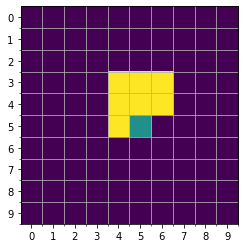

In [6]:
plot_receptive_field(model, data)

Excellent! Like we expected the block considered all the previous blocks in the same row of the analyssed pixel, and the two rows over it.

Note that this receptive field is different from the original PixelCNN. In the original PixelCNN only one row over the analysed pixel influenced in its prediction (when using one masked convolution). In the Gated PixelCNN, the authors used a vertical stack with effective area of 2x3 per vertical convolution. This is not a problem, since the considered pixels still being the ones in past positions. We believe the main coice for this format is to implement an efficient way to apply the masked convolutions without using masking (which we will discuss in future posts).

For the next step, we wll verify a model with 2, 3, 4, and 5 layers

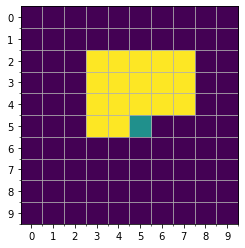

In [7]:
inputs = keras.layers.Input(shape=(height, width, n_channel))
v, h = GatedBlock(mask_type='A', filters=1, kernel_size=3)([inputs, inputs])
v, h = GatedBlock(mask_type='B', filters=1, kernel_size=3)([v, h])
model = tf.keras.Model(inputs=inputs, outputs=h)

plot_receptive_field(model, data)

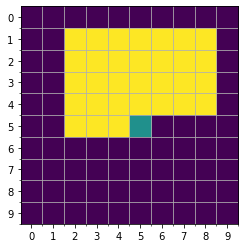

In [8]:
inputs = keras.layers.Input(shape=(height, width, n_channel))
v, h = GatedBlock(mask_type='A', filters=1, kernel_size=3)([inputs, inputs])
v, h = GatedBlock(mask_type='B', filters=1, kernel_size=3)([v, h])
v, h = GatedBlock(mask_type='B', filters=1, kernel_size=3)([v, h])
model = tf.keras.Model(inputs=inputs, outputs=h)

plot_receptive_field(model, data)

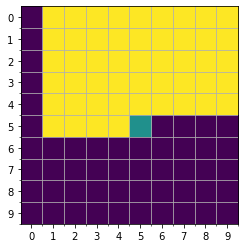

In [9]:
inputs = keras.layers.Input(shape=(height, width, n_channel))
v, h = GatedBlock(mask_type='A', filters=1, kernel_size=3)([inputs, inputs])
v, h = GatedBlock(mask_type='B', filters=1, kernel_size=3)([v, h])
v, h = GatedBlock(mask_type='B', filters=1, kernel_size=3)([v, h])
v, h = GatedBlock(mask_type='B', filters=1, kernel_size=3)([v, h])
model = tf.keras.Model(inputs=inputs, outputs=h)

plot_receptive_field(model, data)

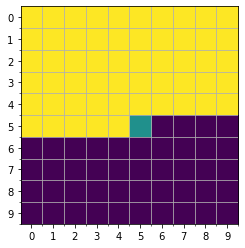

In [10]:
inputs = keras.layers.Input(shape=(height, width, n_channel))
v, h = GatedBlock(mask_type='A', filters=1, kernel_size=3)([inputs, inputs])
v, h = GatedBlock(mask_type='B', filters=1, kernel_size=3)([v, h])
v, h = GatedBlock(mask_type='B', filters=1, kernel_size=3)([v, h])
v, h = GatedBlock(mask_type='B', filters=1, kernel_size=3)([v, h])
v, h = GatedBlock(mask_type='B', filters=1, kernel_size=3)([v, h])
model = tf.keras.Model(inputs=inputs, outputs=h)

plot_receptive_field(model, data)

As you can notice, the Gated PixelCNN does not create blind spots when adding more and more layers.